# Titanic Dataset Analysis

## Preprocessing

In [519]:
%pylab inline
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import operator

!pip install deap
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['f', 'cm', 'std', 'mean']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [520]:
train_data = pd.read_csv('../data/train.csv')
test_data = pd.read_csv('../data/test.csv')

In [521]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [522]:
train_data.set_index(keys=['PassengerId'], drop=True, inplace=True)
test_data.set_index(keys=['PassengerId'], drop=True, inplace=True)

train_data.drop(columns=['Ticket', 'Cabin'], inplace=True)
test_data.drop(columns=['Ticket', 'Cabin'], inplace=True)

train_nan_map = {'Age': train_data['Age'].mean()}
test_nan_map = {'Age': train_data['Age'].mean()}
train_data.fillna(value=train_nan_map, inplace=True)
test_data.fillna(value=test_nan_map, inplace=True)

titles_map = {'Mr':1, 'Miss':2, 'Mrs':3, 'Master':4, 'Rare':5}

data = [train_data, test_data]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
    dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1
    dataset['not_alone'] = dataset['not_alone'].astype(int)
    dataset.drop(columns=['not_alone', 'Parch'], inplace=True)
    
    dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 66, 'Age'] = 6
    
    mean = train_data['Fare'].mean()
    dataset['Fare'] = dataset['Fare'].fillna(mean)
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    dataset.loc[ dataset['Fare'] <= 7.78, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.78) & (dataset['Fare'] <= 8.662), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 8.662) & (dataset['Fare'] <= 14.454), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 26), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 26) & (dataset['Fare'] <= 52.369), 'Fare']   = 4
    dataset.loc[ dataset['Fare'] > 52.369, 'Fare'] = 5
    
    mode = train_data['Embarked'].mode()[0]
    dataset['Embarked'] = dataset['Embarked'].fillna(mode)
    
    dataset.loc[(dataset['Embarked']=='C') & (dataset['Sex']=='male'), 'gender_embarked']=1
    dataset.loc[(dataset['Embarked']=='C') & (dataset['Sex']=='female'), 'gender_embarked']=0
    dataset.loc[(dataset['Embarked']=='Q') & (dataset['Sex']=='male'), 'gender_embarked']=0
    dataset.loc[(dataset['Embarked']=='Q') & (dataset['Sex']=='female'), 'gender_embarked']=1
    dataset.loc[(dataset['Embarked']=='S') & (dataset['Sex']=='male'), 'gender_embarked']=0
    dataset.loc[(dataset['Embarked']=='S') & (dataset['Sex']=='female'), 'gender_embarked']=1
    
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    
    # replace titles with a more common title or as Rare
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
    # convert titles into numbers
    dataset['Title'] = dataset['Title'].map(titles_map)
    
    # filling NaN with 0, to get safe
    dataset['Title'] = dataset['Title'].fillna(0)
    dataset.drop(columns=['Name'], inplace=True)
    
    dataset['age_class']=dataset['Age']*dataset['Pclass']

columns_map={'Embarked':{'C':1.643, 'Q':1.156, 'S':1}, 'Sex':{'male':0, 'female':1}}
train_data.replace(columns_map, inplace=True)
test_data.replace(columns_map, inplace=True)

X_train=train_data.loc[:,train_data.columns!='Survived']
y_train=train_data.loc[:,'Survived']

In [523]:
#make splits
X_train = train_data.loc[:, train_data.columns != 'Survived']
y_train = train_data.loc[:, 'Survived']

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=10)

In [524]:
X_train.head()

,Pclass,Sex,Age,SibSp,Fare,Embarked,relatives,gender_embarked,Title,age_class
PassengerId,,,,,,,,,,
464,2,0,6.0,0,2,1.000,0,0.0,1,12.0
160,3,0,4.0,8,5,1.000,10,0.0,4,12.0
48,3,1,4.0,0,0,1.156,0,1.0,2,12.0
403,3,1,2.0,1,2,1.000,1,1.0,2,6.0
619,2,1,0.0,2,4,1.000,3,1.0,2,0.0


In [525]:
cols = X_train.columns
X_train[cols[1]]

PassengerId
464    0
160    0
48     1
403    1
619    1
      ..
370    1
321    0
528    0
126    0
266    0
Name: Sex, Length: 596, dtype: int64

## Machine Learning Algorithms

In [623]:
from sklearn.neural_network import MLPClassifier

mlp_clf = MLPClassifier(random_state=100, max_iter=1200).fit(X_train.values, y_train.values)
print(mlp_clf.score(X_test.values, y_test.values))
y_pred = mlp_clf.predict(X_test.values)
y_truth = y_test.values
cm = confusion_matrix(y_truth, y_pred)
print(cm.ravel())

0.823728813559322
[166  25  27  77]


In [634]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(max_depth=5, random_state=10)
rf_clf.fit(X_train.values, y_train.values)
print(rf_clf.score(X_test.values, y_test.values))
y_pred = rf_clf.predict(X_test.values)
y_truth = y_test.values
cm = confusion_matrix(y_truth, y_pred)
print(cm.ravel())

0.847457627118644
[170  21  24  80]


In [528]:
from sklearn.naive_bayes import GaussianNB

gnb_clf = GaussianNB()
gnb_clf.fit(X_train.values, y_train.values)
print(gnb_clf.score(X_test.values, y_test.values))
y_pred = gnb_clf.predict(X_test.values)
y_truth = y_test.values
cm = confusion_matrix(y_truth, y_pred)
print(cm.ravel())

0.7932203389830509
[151  40  21  83]


In [632]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

svm_clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
svm_clf.fit(X_train.values, y_train.values)
print(svm_clf.score(X_test.values, y_test.values))
y_pred = svm_clf.predict(X_test.values)
y_truth = y_test.values
cm = confusion_matrix(y_truth, y_pred)
print(cm.ravel())

0.847457627118644
[168  23  22  82]


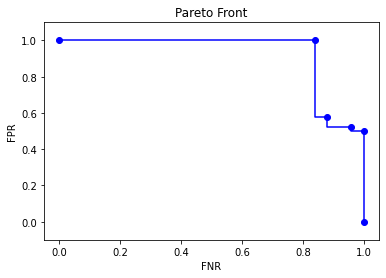

Area Under Curve: 0.925


In [711]:
fp = np.array([0, 20, 21, 23, 40, 40])
fp = fp / np.max(fp)
fn = np.array([25, 25, 24, 22, 21, 0])
fn = fn / np.max(fn)

fp = (fp - np.min(fp)) / (np.max(fp) - np.min(fp))
fn = (fn - np.min(fn)) / (np.max(fn) - np.min(fn))

plt.ylim(bottom=-0.1, top=1.1)
plt.scatter(fn, fp, color='b')
plt.plot(fn, fp, color='b', drawstyle='steps-post')
plt.xlabel("FNR")
plt.ylabel("FPR")
plt.title("Pareto Front")
plt.show()

"""Calculate area under curve with least squares method"""
print("Area Under Curve: %s" % (np.sum(np.abs(np.diff(fn))*fp[:-1])))

In [712]:
predictions = rf_clf.predict(test_data.values)
pred_df = pd.DataFrame(predictions, index=test_data.index, columns=['Survived'])
pred_df.to_csv('ml_predictions.csv', header=True, sep=',')

## Multi Objective Genetic Programming (MOGP)

In [684]:
#initialize multi-objective problem
creator.create("FitnessMin", base.Fitness, weights=(-1.0,-1.0))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [685]:
random.seed(25)

# pset = gp.PrimitiveSet("MAIN", arity=1)
pset = gp.PrimitiveSetTyped("MAIN", [float, bool, float, float, float, float, float, bool, float, float], bool)
pset.addPrimitive(np.add, [float, float], float)
pset.addPrimitive(np.subtract, [float, float], float)
pset.addPrimitive(np.multiply, [float, float], float)

#adding boolean logic
pset.addPrimitive(np.logical_or, [bool, bool], bool)
pset.addPrimitive(np.logical_and, [bool, bool], bool)
pset.addPrimitive(np.logical_not, [bool], bool)
pset.addPrimitive(np.greater, [float, float], bool)
pset.addPrimitive(np.equal, [float, float], bool)
# pset.addTerminal(3.0, float)
# pset.addTerminal(1, bool)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [686]:
def evaluation_func_multi(individual, x_train, y_train, pset):
    func = gp.compile(expr=individual, pset=pset)
    predictions = func(x_train[cols[0]],x_train[cols[1]],x_train[cols[2]],x_train[cols[3]],x_train[cols[4]],x_train[cols[5]],x_train[cols[6]],x_train[cols[7]],x_train[cols[8]],x_train[cols[9]])
    confusion = confusion_matrix(y_train, predictions)
    FN = confusion[1,0]
    FP = confusion[0,1]
    positives = np.sum(confusion, axis=1)[0]
    negatives = np.sum(confusion, axis=1)[1]
    
    if FN >= positives or FP > negatives:
        return (1000000, 1000000)
    e1 = FN**2 + len(individual) * 20
    e2 = FP**2 + len(individual) * 20
    return (e1, e2)

In [687]:
toolbox.register("evaluate", evaluation_func_multi, x_train=X_train, y_train=y_train, pset=pset)
toolbox.register("select", tools.selLexicase) #randomly choose order of objectives
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [696]:
gen = range(50)
avg_list = []
max_list = []
min_list = []

pop = toolbox.population(n=100)

# Evaluate the entire population
fitnesses = list(map(toolbox.evaluate, pop))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

# Begin the evolution
for g in gen:
    print("-- Generation %i --" % g)

    # Select the next generation individuals
    offspring = toolbox.select(pop, len(pop))
    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))

    # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < 0.5:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < 0.2:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Replace population
    pop[:] = offspring

    # Gather all the fitnesses in one list and print the stats
    fits = [ind.fitness.values[0] + ind.fitness.values[1] for ind in pop]
#     print(fits)

    length = len(pop)
    mean = sum(fits) / length
    sum2 = sum(x*x for x in fits)
    std = abs(sum2 / length - mean**2)**0.5
    g_max = max(fits)
    g_min = min(fits)
        
    avg_list.append(mean)
    max_list.append(g_max)
    min_list.append(g_min)

    print("  Min %s" % g_min)
    print("  Max %s" % g_max)
    print("  Avg %s" % mean)
    print("  Std %s" % std)

print("-- End of (successful) evolution --")

best_ind = tools.selLexicase(pop, 1)[0]
print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))

-- Generation 0 --
  Min 0.4420056383407168
  Max 1.881745871929118
  Avg 1.054284132098268
  Std 0.6160226368255283
-- Generation 1 --
  Min 0.4420056383407168
  Max 1.8365384615384615
  Avg 1.1205779299234795
  Std 0.6261552312997353
-- Generation 2 --


/var/folders/3t/xkpc06q95n18xb2k044pxdq40000gp/T/ipykernel_31559/581451859.py:49: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum2 = sum(x*x for x in fits)
/var/folders/3t/xkpc06q95n18xb2k044pxdq40000gp/T/ipykernel_31559/581451859.py:49: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum2 = sum(x*x for x in fits)
/var/folders/3t/xkpc06q95n18xb2k044pxdq40000gp/T/ipykernel_31559/581451859.py:49: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum2 = sum(x*x for x in fits)


  Min 0.511377366089408
  Max 1.8365384615384615
  Avg 1.1337595650422876
  Std 0.6271728791941346
-- Generation 3 --
  Min 0.4420056383407168
  Max 1.8538562223117196
  Avg 0.9804832863471609
  Std 0.590064597302217
-- Generation 4 --


/var/folders/3t/xkpc06q95n18xb2k044pxdq40000gp/T/ipykernel_31559/581451859.py:49: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum2 = sum(x*x for x in fits)
/var/folders/3t/xkpc06q95n18xb2k044pxdq40000gp/T/ipykernel_31559/581451859.py:49: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum2 = sum(x*x for x in fits)


  Min 0.4420056383407168
  Max 1.9390354409987918
  Avg 1.0466643173580348
  Std 0.614199876741589
-- Generation 5 --
  Min 0.4420056383407168
  Max 1.8627164720096656
  Avg 1.201442307692308
  Std 0.6280334161316549
-- Generation 6 --


/var/folders/3t/xkpc06q95n18xb2k044pxdq40000gp/T/ipykernel_31559/581451859.py:49: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum2 = sum(x*x for x in fits)
/var/folders/3t/xkpc06q95n18xb2k044pxdq40000gp/T/ipykernel_31559/581451859.py:49: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum2 = sum(x*x for x in fits)


  Min 0.511377366089408
  Max 1.8365384615384615
  Avg 1.1924315344341523
  Std 0.6013945625458199
-- Generation 7 --
  Min 0.4420056383407168
  Max 1.852245267821184
  Avg 1.1517443616592833
  Std 0.5923036969634858
-- Generation 8 --


/var/folders/3t/xkpc06q95n18xb2k044pxdq40000gp/T/ipykernel_31559/581451859.py:49: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum2 = sum(x*x for x in fits)
/var/folders/3t/xkpc06q95n18xb2k044pxdq40000gp/T/ipykernel_31559/581451859.py:49: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum2 = sum(x*x for x in fits)


  Min 0.435914216673379
  Max 1.8530004027386227
  Avg 1.062194925493355
  Std 0.5938755512581736
-- Generation 9 --
  Min 0.4669250906161901
  Max 1.8391059202577527
  Avg 1.1526349174385822
  Std 0.5915184077477099
-- Generation 10 --


/var/folders/3t/xkpc06q95n18xb2k044pxdq40000gp/T/ipykernel_31559/581451859.py:49: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum2 = sum(x*x for x in fits)
/var/folders/3t/xkpc06q95n18xb2k044pxdq40000gp/T/ipykernel_31559/581451859.py:49: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum2 = sum(x*x for x in fits)


  Min 0.5061417639951672
  Max 1.8696637132501006
  Avg 1.2065107732581555
  Std 0.5953498790341036
-- Generation 11 --
  Min 0.511377366089408
  Max 1.8422271445831657
  Avg 1.187632400322191
  Std 0.5851836237824715
-- Generation 12 --


/var/folders/3t/xkpc06q95n18xb2k044pxdq40000gp/T/ipykernel_31559/581451859.py:49: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum2 = sum(x*x for x in fits)
/var/folders/3t/xkpc06q95n18xb2k044pxdq40000gp/T/ipykernel_31559/581451859.py:49: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum2 = sum(x*x for x in fits)


  Min 0.435914216673379
  Max 1.8417740636327022
  Avg 1.1933472613773661
  Std 0.5878883418138011
-- Generation 13 --
  Min 0.511377366089408
  Max 1.8627164720096656
  Avg 1.1013537051953284
  Std 0.5896312260653818
-- Generation 14 --


/var/folders/3t/xkpc06q95n18xb2k044pxdq40000gp/T/ipykernel_31559/581451859.py:49: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum2 = sum(x*x for x in fits)
/var/folders/3t/xkpc06q95n18xb2k044pxdq40000gp/T/ipykernel_31559/581451859.py:49: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum2 = sum(x*x for x in fits)


  Min 0.4420056383407168
  Max 1.8417740636327022
  Avg 1.0810989730165121
  Std 0.5925416173365586
-- Generation 15 --
  Min 0.4420056383407168
  Max 1.8627164720096656
  Avg 1.1494794603302458
  Std 0.589845541466203
-- Generation 16 --


/var/folders/3t/xkpc06q95n18xb2k044pxdq40000gp/T/ipykernel_31559/581451859.py:49: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum2 = sum(x*x for x in fits)
/var/folders/3t/xkpc06q95n18xb2k044pxdq40000gp/T/ipykernel_31559/581451859.py:49: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum2 = sum(x*x for x in fits)


  Min 0.4420056383407168
  Max 1.8731876761981474
  Avg 1.20481725734998
  Std 0.5941385062485846
-- Generation 17 --
  Min 0.4420056383407168
  Max 1.8696637132501006
  Avg 1.1801540475231576
  Std 0.5921461123773053
-- Generation 18 --


/var/folders/3t/xkpc06q95n18xb2k044pxdq40000gp/T/ipykernel_31559/581451859.py:49: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum2 = sum(x*x for x in fits)
/var/folders/3t/xkpc06q95n18xb2k044pxdq40000gp/T/ipykernel_31559/581451859.py:49: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum2 = sum(x*x for x in fits)


  Min 0.511377366089408
  Max 1.8696637132501006
  Avg 1.1854767418445429
  Std 0.5984339832647553
-- Generation 19 --
  Min 0.511377366089408
  Max 1.8365384615384615
  Avg 1.1924496576721706
  Std 0.5957019293501762
-- Generation 20 --


/var/folders/3t/xkpc06q95n18xb2k044pxdq40000gp/T/ipykernel_31559/581451859.py:49: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum2 = sum(x*x for x in fits)
/var/folders/3t/xkpc06q95n18xb2k044pxdq40000gp/T/ipykernel_31559/581451859.py:49: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum2 = sum(x*x for x in fits)


  Min 0.4420056383407168
  Max 1.8365384615384615
  Avg 1.1573011478050745
  Std 0.5921734717115299
-- Generation 21 --
  Min 0.4420056383407168
  Max 1.8426298832057995
  Avg 1.0928277285541685
  Std 0.596049987212717
-- Generation 22 --


/var/folders/3t/xkpc06q95n18xb2k044pxdq40000gp/T/ipykernel_31559/581451859.py:49: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum2 = sum(x*x for x in fits)
/var/folders/3t/xkpc06q95n18xb2k044pxdq40000gp/T/ipykernel_31559/581451859.py:49: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum2 = sum(x*x for x in fits)


  Min 0.4669250906161901
  Max 1.8365384615384615
  Avg 1.1809821788159485
  Std 0.5881240094079462
-- Generation 23 --
  Min 0.4669250906161901
  Max 1.9390354409987918
  Avg 1.253555175191301
  Std 0.5819965626285474
-- Generation 24 --


/var/folders/3t/xkpc06q95n18xb2k044pxdq40000gp/T/ipykernel_31559/581451859.py:49: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum2 = sum(x*x for x in fits)
/var/folders/3t/xkpc06q95n18xb2k044pxdq40000gp/T/ipykernel_31559/581451859.py:49: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum2 = sum(x*x for x in fits)


  Min 0.511377366089408
  Max 1.8696637132501006
  Avg 1.2282657068062826
  Std 0.5778659550503105
-- Generation 25 --
  Min 0.4420056383407168
  Max 1.847009665726943
  Avg 1.1767433548127266
  Std 0.5950246883898327
-- Generation 26 --


/var/folders/3t/xkpc06q95n18xb2k044pxdq40000gp/T/ipykernel_31559/581451859.py:49: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum2 = sum(x*x for x in fits)
/var/folders/3t/xkpc06q95n18xb2k044pxdq40000gp/T/ipykernel_31559/581451859.py:49: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum2 = sum(x*x for x in fits)


  Min 0.4420056383407168
  Max 1.8972513089005236
  Avg 1.1773660894079743
  Std 0.5926764751402068
-- Generation 27 --
  Min 0.511377366089408
  Max 1.8365384615384615
  Avg 1.1841935159081758
  Std 0.5963683668975901
-- Generation 28 --


/var/folders/3t/xkpc06q95n18xb2k044pxdq40000gp/T/ipykernel_31559/581451859.py:49: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum2 = sum(x*x for x in fits)
/var/folders/3t/xkpc06q95n18xb2k044pxdq40000gp/T/ipykernel_31559/581451859.py:49: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum2 = sum(x*x for x in fits)


  Min 0.46903946838501814
  Max 1.9390354409987918
  Avg 1.099770942408377
  Std 0.5873041309822246
-- Generation 29 --
  Min 0.4420056383407168
  Max 1.8574808699154248
  Avg 1.2140394683850182
  Std 0.5880684251414982
-- Generation 30 --


/var/folders/3t/xkpc06q95n18xb2k044pxdq40000gp/T/ipykernel_31559/581451859.py:49: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum2 = sum(x*x for x in fits)
/var/folders/3t/xkpc06q95n18xb2k044pxdq40000gp/T/ipykernel_31559/581451859.py:49: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum2 = sum(x*x for x in fits)


  Min 0.511377366089408
  Max 1.9390354409987918
  Avg 1.1461775070479259
  Std 0.5983402774862006
-- Generation 31 --
  Min 0.4420056383407168
  Max 1.8696637132501006
  Avg 1.1340228554168343
  Std 0.6000615905339584
-- Generation 32 --


/var/folders/3t/xkpc06q95n18xb2k044pxdq40000gp/T/ipykernel_31559/581451859.py:49: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum2 = sum(x*x for x in fits)
/var/folders/3t/xkpc06q95n18xb2k044pxdq40000gp/T/ipykernel_31559/581451859.py:49: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum2 = sum(x*x for x in fits)


  Min 0.511377366089408
  Max 1.8365384615384615
  Avg 1.112398308497785
  Std 0.5910771389841818
-- Generation 33 --
  Min 0.4420056383407168
  Max 1.8538562223117196
  Avg 1.1944296214256946
  Std 0.5902548689211803
-- Generation 34 --


/var/folders/3t/xkpc06q95n18xb2k044pxdq40000gp/T/ipykernel_31559/581451859.py:49: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum2 = sum(x*x for x in fits)
/var/folders/3t/xkpc06q95n18xb2k044pxdq40000gp/T/ipykernel_31559/581451859.py:49: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum2 = sum(x*x for x in fits)


  Min 0.4420056383407168
  Max 1.8696637132501006
  Avg 1.009333971002819
  Std 0.5699246405048473
-- Generation 35 --


/var/folders/3t/xkpc06q95n18xb2k044pxdq40000gp/T/ipykernel_31559/581451859.py:49: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum2 = sum(x*x for x in fits)
/var/folders/3t/xkpc06q95n18xb2k044pxdq40000gp/T/ipykernel_31559/581451859.py:49: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum2 = sum(x*x for x in fits)


  Min 0.4869109947643979
  Max 1.834726137736609
  Avg 1.0581212243254128
  Std 0.5734727560708209
-- Generation 36 --
  Min 0.42277486910994766
  Max 1.9294200563834072
  Avg 0.9866180024164316
  Std 0.5984088736297976
-- Generation 37 --


/var/folders/3t/xkpc06q95n18xb2k044pxdq40000gp/T/ipykernel_31559/581451859.py:49: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum2 = sum(x*x for x in fits)
/var/folders/3t/xkpc06q95n18xb2k044pxdq40000gp/T/ipykernel_31559/581451859.py:49: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum2 = sum(x*x for x in fits)


  Min 0.42277486910994766
  Max 1.9250402738622634
  Avg 0.9947467780910189
  Std 0.6009832185606361
-- Generation 38 --
  Min 0.42277486910994766
  Max 1.9390354409987918
  Avg 1.099156262585582
  Std 0.6038231876715843
-- Generation 39 --


/var/folders/3t/xkpc06q95n18xb2k044pxdq40000gp/T/ipykernel_31559/581451859.py:49: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum2 = sum(x*x for x in fits)
/var/folders/3t/xkpc06q95n18xb2k044pxdq40000gp/T/ipykernel_31559/581451859.py:49: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum2 = sum(x*x for x in fits)


  Min 0.42277486910994766
  Max 1.9294200563834072
  Avg 0.9540898107128474
  Std 0.5893197177451405
-- Generation 40 --
  Min 0.42277486910994766
  Max 1.9294200563834072
  Avg 1.0886181031010873
  Std 0.6138717241717784
-- Generation 41 --


/var/folders/3t/xkpc06q95n18xb2k044pxdq40000gp/T/ipykernel_31559/581451859.py:49: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum2 = sum(x*x for x in fits)
/var/folders/3t/xkpc06q95n18xb2k044pxdq40000gp/T/ipykernel_31559/581451859.py:49: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum2 = sum(x*x for x in fits)


  Min 0.4420056383407168
  Max 1.884514699959726
  Avg 1.0579722110350382
  Std 0.6043240398016899
-- Generation 42 --
  Min 0.42277486910994766
  Max 1.8269230769230769
  Avg 0.9809101892871527
  Std 0.5905138538801347
-- Generation 43 --


/var/folders/3t/xkpc06q95n18xb2k044pxdq40000gp/T/ipykernel_31559/581451859.py:49: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum2 = sum(x*x for x in fits)
/var/folders/3t/xkpc06q95n18xb2k044pxdq40000gp/T/ipykernel_31559/581451859.py:49: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum2 = sum(x*x for x in fits)


  Min 0.42277486910994766
  Max 1.9390354409987918
  Avg 1.018646294804672
  Std 0.6000858725801724
-- Generation 44 --
  Min 0.41134716069271043
  Max 1.9294200563834072
  Avg 1.0388582360048328
  Std 0.6025787651448976
-- Generation 45 --


/var/folders/3t/xkpc06q95n18xb2k044pxdq40000gp/T/ipykernel_31559/581451859.py:49: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum2 = sum(x*x for x in fits)
/var/folders/3t/xkpc06q95n18xb2k044pxdq40000gp/T/ipykernel_31559/581451859.py:49: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum2 = sum(x*x for x in fits)


  Min 0.42277486910994766
  Max 1.9294200563834072
  Avg 1.0562062021747884
  Std 0.6066460812259444
-- Generation 46 --
  Min 0.4420056383407168
  Max 1.8269230769230769
  Avg 1.0045534635521547
  Std 0.5934655626182553
-- Generation 47 --


/var/folders/3t/xkpc06q95n18xb2k044pxdq40000gp/T/ipykernel_31559/581451859.py:49: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum2 = sum(x*x for x in fits)
/var/folders/3t/xkpc06q95n18xb2k044pxdq40000gp/T/ipykernel_31559/581451859.py:49: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum2 = sum(x*x for x in fits)


  Min 0.42277486910994766
  Max 1.9294200563834072
  Avg 1.1190203383004427
  Std 0.6038490748163843
-- Generation 48 --
  Min 0.41134716069271043
  Max 1.9294200563834072
  Avg 1.0025644381796213
  Std 0.5939146215584012
-- Generation 49 --
  Min 0.42277486910994766
  Max 1.8801349174385824
  Avg 1.0038386024969794
  Std 0.5957799424021228
-- End of (successful) evolution --
Best individual is logical_and(equal(ARG3, subtract(ARG9, ARG8)), logical_and(logical_and(logical_and(ARG1, logical_not(equal(multiply(multiply(add(multiply(ARG4, ARG9), ARG0), subtract(ARG9, ARG8)), multiply(add(multiply(ARG4, ARG9), multiply(multiply(ARG8, ARG0), ARG4)), ARG0)), add(ARG2, ARG6)))), ARG1), ARG1)), (0.4869109947643979, 0.0)


/var/folders/3t/xkpc06q95n18xb2k044pxdq40000gp/T/ipykernel_31559/581451859.py:49: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum2 = sum(x*x for x in fits)


In [697]:
def pareto_dominance(ind1, ind2):
    not_equal = False
    for value_1, value_2 in zip(ind1.fitness.values, ind2.fitness.values):
        if value_1 > value_2:
            return 0
        elif value_1 < value_2:
            not_equal = True
    return not_equal

In [698]:
non_dominated_ind = []
print(len(pop))
for ind1 in pop:
    cur = [pareto_dominance(ind2,ind1) for ind2 in pop]
    if True not in cur:
        non_dominated_ind.append(ind1)
print(len(non_dominated_ind))
uniq = []
for ind in non_dominated_ind:
    if ind not in uniq:
        uniq.append(ind)
for ind in uniq:
    print(ind.fitness.values)

100
78
(0.4869109947643979, 0.0)
(0.0, 1.6923076923076923)
(0.4869109947643979, 0.0)
(0.0, 1.6923076923076923)
(0.4869109947643979, 0.0)
(0.0, 1.6923076923076923)
(0.4869109947643979, 0.0)
(0.0, 1.6923076923076923)
(0.0, 1.6923076923076923)
(0.4869109947643979, 0.0)
(0.0, 1.6923076923076923)
(0.0, 1.6923076923076923)
(0.0, 1.6923076923076923)
(0.0, 1.6923076923076923)
(0.4869109947643979, 0.0)
(0.0, 1.6923076923076923)
(0.0, 1.6923076923076923)
(0.4869109947643979, 0.0)
(0.4869109947643979, 0.0)
(0.0, 1.6923076923076923)
(0.450261780104712, 0.07692307692307693)
(0.4869109947643979, 0.0)
(0.4869109947643979, 0.0)
(0.4869109947643979, 0.0)
(0.0, 1.6923076923076923)
(0.0, 1.6923076923076923)
(0.4869109947643979, 0.0)
(0.0, 1.6923076923076923)
(0.4869109947643979, 0.0)
(0.4869109947643979, 0.0)
(0.4816753926701571, 0.009615384615384616)
(0.4869109947643979, 0.0)
(0.0, 1.6923076923076923)
(0.0, 1.6923076923076923)
(0.3298429319371728, 0.16346153846153846)
(0.4869109947643979, 0.0)
(0.486910

In [699]:
def evaluation_func_pred(individual, x_test, pset):
    func = gp.compile(expr=individual, pset=pset)
    predictions = func(x_test[cols[0]],x_test[cols[1]],x_test[cols[2]],x_test[cols[3]],x_test[cols[4]],x_test[cols[5]],x_test[cols[6]],x_test[cols[7]],x_test[cols[8]],x_test[cols[9]])
    return predictions

In [700]:
toolbox.register("evaluate", evaluation_func_pred, x_test=test_data, pset=pset)
predictions = list(map(toolbox.evaluate, uniq))
predictions = [list(predictions[i]) for i in range(len(predictions))]
predictions = np.array(predictions).T
predictions = predictions.astype('int32')
print(predictions)
# df = pd.DataFrame(predictions)
# df.head()

[[0 1 0 ... 0 0 0]
 [0 1 0 ... 0 1 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]]


In [701]:
keep_cols = [0]
predictions = predictions[:, [i for i in range(predictions.shape[1]) if i in keep_cols]]
df = pd.DataFrame(predictions, index=test_data.index, columns=['Survived'])
with open("gp_predictions.csv", "w") as f:
    df.to_csv(f)

In [702]:
def evaluation_func_testing(individual, x_train, y_train, pset):
    func = gp.compile(expr=individual, pset=pset)
    predictions = func(x_train[cols[0]],x_train[cols[1]],x_train[cols[2]],x_train[cols[3]],x_train[cols[4]],x_train[cols[5]],x_train[cols[6]],x_train[cols[7]],x_train[cols[8]],x_train[cols[9]])
    confusion = confusion_matrix(y_train, predictions)
    FN = confusion[1,0]
    FP = confusion[0,1]
    positives = np.sum(confusion, axis=1)[0]
    negatives = np.sum(confusion, axis=1)[1]
    
    return (FN/positives, FP/negatives)

toolbox.register("evaluate", evaluation_func_testing, x_train=X_test, y_train=y_test, pset=pset)
fitnesses = list(map(toolbox.evaluate, uniq))

# add bounds to pareto front
fitnesses.append((1, 0))
fitnesses.append((0, 1))

fitnesses.sort(key = lambda x: x[0])

fitness_1 = list()
fitness_2 = list()

for i in range(len(fitnesses)):
    if (fitnesses[i][0] > 1 or fitnesses[i][0] < 0 or fitnesses[i][1] > 1 or fitnesses[i][1] < 0):
        continue;
    fitness_1.append(fitnesses[i][0])
    fitness_2.append(fitnesses[i][1])

[0, 0.17277486910994763, 0.3298429319371728, 0.450261780104712, 0.4816753926701571, 0.4869109947643979, 0.4869109947643979, 0.4869109947643979, 0.4869109947643979, 0.4869109947643979, 0.4869109947643979, 0.4869109947643979, 0.4869109947643979, 0.4869109947643979, 0.4869109947643979, 0.4869109947643979, 0.4869109947643979, 0.4869109947643979, 0.4869109947643979, 0.4869109947643979, 0.4869109947643979, 0.4869109947643979, 0.4869109947643979, 0.4869109947643979, 0.4869109947643979, 0.4869109947643979, 0.4869109947643979, 0.4869109947643979, 1]
[1, 0.25, 0.16346153846153846, 0.07692307692307693, 0.009615384615384616, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0]


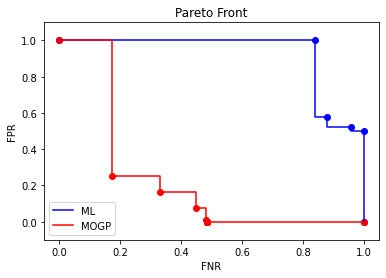

Area Under Curve (ML): 0.925
Area Under Curve (MOGP): 0.234192509061619


In [713]:
# Pareto front (ML)
fp = np.array([0, 20, 21, 23, 40, 40])
fp = fp / np.max(fp)
fn = np.array([25, 25, 24, 22, 21, 0])
fn = fn / np.max(fn)

fp = (fp - np.min(fp)) / (np.max(fp) - np.min(fp))
fn = (fn - np.min(fn)) / (np.max(fn) - np.min(fn))

plt.ylim(bottom=-0.1, top=1.1)
plt.scatter(fn, fp, color='b')
plt.plot(fn, fp, color='b', drawstyle='steps-post')

#Pareto front (MOGP)
print(fitness_1)
print(fitness_2)

plt.scatter(fitness_1, fitness_2, color='r')
plt.plot(fitness_1, fitness_2, color='r', drawstyle='steps-post')
plt.xlabel("FNR")
plt.ylabel("FPR")
plt.title("Pareto Front")
plt.legend(["ML", "MOGP"])
plt.show()

f1 = np.array(fitness_1)
f2 = np.array(fitness_2)

"""Calculate area under curve with least squares method"""
print("Area Under Curve (ML): %s" % (np.sum(np.abs(np.diff(fn))*fp[:-1])))
print("Area Under Curve (MOGP): %s" % (np.sum(np.abs(np.diff(f1))*f2[:-1])))

## Summary and Analysis

- For machine learning, we used 4 algorithms, multilayer perceptron, random forest, gaussian naive bayes, and support vector machine.
- The pareto front created by these 4 machine learning algorithms had an AUC of 0.925.

- For multi-objective genetic programming, we ran one evolution for 50 generations.
- The pareto front created by the MOGP individuals had an AUC of 0.234192509061619.

- The significant improvement in the minimization of AUC by genetic programming (vs. machine learning) is most likely due to having more non-dominant individuals.
- The genetic programming algorithm began with 100 individuals that were selected, mated, and mutated over the course of 1 evolution of 50 generations. This would allow the increased probability of creating more pareto dominant individuals.
- When performing machine learning algorithms on the dataset, the individual performances of the algorithms were very similar in terms of false positives and false negatives, and averaged around 80% accuracy. As a result, the machine learning algorithms tended to be codominant, forcing me to pick a less accurate algorithm in order to create a pareto front with 4 individuals.
- As a result, I believe that the metric of using AUC to compare machine learning algorithms and the individuals created by genetic programming is not too great.

- After submitting the predicted survived passengers from both the machine learning algorithms (specifically random forest) and genetic programming individuals, I found that the prediction by the random forest algorithm received a score of 0.77751 while the prediction by the MOGP individual was 0.64114.